In [124]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-shopping-latest-trends-dataset/shopping_trends.csv


In this notebook, I aim to answer the following questions based on the attached dataset, which contains information about customer demographics, their shopping preferences, product categories, purchase amounts, and related details such as payment methods, shipping types, and subscription statuses.

### Questions:
1. **What are the most frequently purchased product categories in different seasons?**  

2. **Is there a relationship between the customer's age and the average review rating given by them?**

3. **Which product color is the most popular among customers from different locations?**

4. **What payment methods are preferred by customers depending on the frequency of their purchases?**

5. **Do customers with a subscription ("Subscription Status") use promotional codes more frequently?**


Before we dive into answering the questions, let's first review the dataset to understand its structure, check for missing values, and perform any necessary cleaning steps. This ensures our analysis is accurate and reliable.

In [125]:
# Load data to df variable

data = pd.read_csv('/kaggle/input/customer-shopping-latest-trends-dataset/shopping_trends.csv')
df = data.copy()

In [126]:
# Display the first 5 rows to get an overview of the data.

df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


In [127]:
# Verify shape of dataset

print(f'This dataset contain {df.shape[0]} rows and {df.shape[1]} columns.') 

This dataset contain 3900 rows and 19 columns.


In [128]:
# Check for missing values and idedntify data types for each column

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               3900 non-null   int64  
 1   Age                       3900 non-null   int64  
 2   Gender                    3900 non-null   object 
 3   Item Purchased            3900 non-null   object 
 4   Category                  3900 non-null   object 
 5   Purchase Amount (USD)     3900 non-null   int64  
 6   Location                  3900 non-null   object 
 7   Size                      3900 non-null   object 
 8   Color                     3900 non-null   object 
 9   Season                    3900 non-null   object 
 10  Review Rating             3900 non-null   float64
 11  Subscription Status       3900 non-null   object 
 12  Payment Method            3900 non-null   object 
 13  Shipping Type             3900 non-null   object 
 14  Discount

This dataset contains 3 different data types. Let's focus on the object data type and check how many unique values each column contains. This step will help us to slightly reduce memory usage of thia loaded dataset.

In [129]:
# Check for 'object' type columns and convert to 'category' if unique values <= 10

for column in df.select_dtypes(include=['object']).columns:
    print(column, df[column].nunique())

    if  df[column].nunique() <= 10:
        df[column] = df[column].astype('category')

Gender 2
Item Purchased 25
Category 4
Location 50
Size 4
Color 25
Season 4
Subscription Status 2
Payment Method 6
Shipping Type 6
Discount Applied 2
Promo Code Used 2
Preferred Payment Method 6
Frequency of Purchases 7


In [130]:
print(f'This dataset contains {df.duplicated().sum()} duplicated rows. Awesome!')

This dataset contains 0 duplicated rows. Awesome!


In [131]:
# Let's describe all numeric column 

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,3900.0,1950.500000,1125.977353,1.0,975.75,1950.5,2925.25,3900.0
Age,3900.0,44.068462,15.207589,18.0,31.00,44.0,57.00,70.0
Purchase Amount (USD),3900.0,59.764359,23.685392,20.0,39.00,60.0,81.00,100.0
Review Rating,3900.0,3.749949,0.716223,2.5,3.10,3.7,4.40,5.0
Previous Purchases,3900.0,25.351538,14.447125,1.0,13.00,25.0,38.00,50.0


# Short summary about numeric columns

Based on the summary above, we can observe that the age of customers ranges from 18 to 70 years (wide demographic base), with an average age of 44. Each customer spent an average of approximately 60 USD on purchases (with amounts ranging from 20 USD to 100 USD). The average rating given by customers is about 3.7. This result is close to the median, suggesting that the distribution of this variable is probably normal (We will verify this later below). Half of the customers review rated below 3.7, and half rated above it. This dataset contain 3900 unique customers.

In [132]:
# Verifty number of null values
df.isnull().sum()

Customer ID                 0
Age                         0
Gender                      0
Item Purchased              0
Category                    0
Purchase Amount (USD)       0
Location                    0
Size                        0
Color                       0
Season                      0
Review Rating               0
Subscription Status         0
Payment Method              0
Shipping Type               0
Discount Applied            0
Promo Code Used             0
Previous Purchases          0
Preferred Payment Method    0
Frequency of Purchases      0
dtype: int64

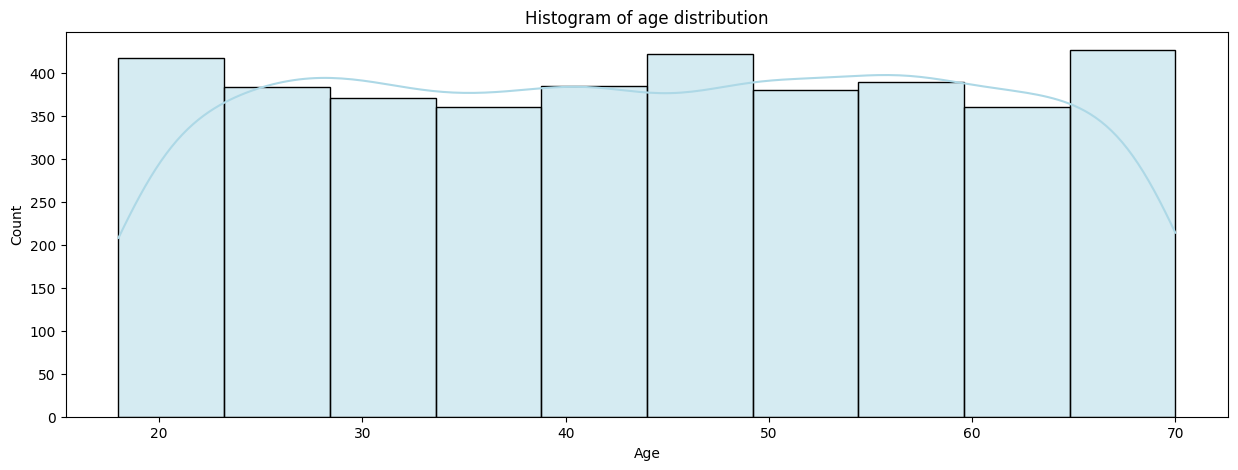

In [133]:
plt.figure(figsize=(15,5))
plt.title('Histogram of age distribution')
sns.histplot(data=df, x='Age', color ='lightblue', bins=10, kde= True, stat = 'count')
plt.show()

The distribution for the Age column is relatively uniform—the number of customers in each age group is similar, with slight increases at the beginning, in the 40-50 range, and at the end of the range.

In [134]:
gender = df['Gender'].value_counts(normalize=True) *100
print(f'{round(gender[0])}% of customers are male, while {round(gender[1])}% are female. ')

68% of customers are male, while 32% are female. 


In [135]:
avg_age_gender = df.groupby('Gender')['Age'].mean() 

print('The average age for each gender is 44 years.')


The average age for each gender is 44 years.


In [136]:
products = df.groupby(['Category', 'Item Purchased']).size().reset_index(name='Count')
products = products.loc[products['Count'] >0]
products_sorted = products.sort_values(by=['Category','Count'], ascending=[True,False])

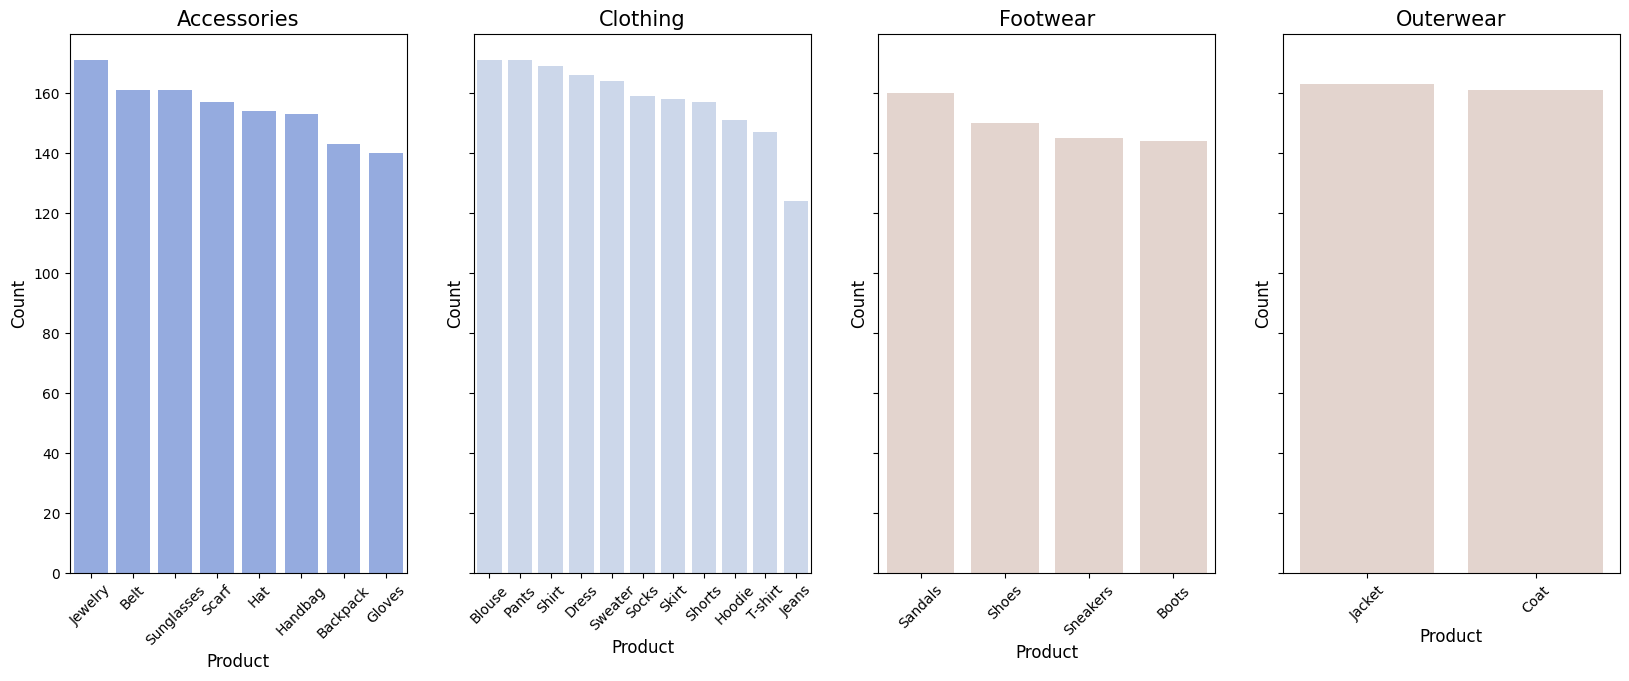

In [172]:

#first idea
# sns.barplot(data=products_sorted, x='Item Purchased', y='Count', hue='Category', width=0.8, dodge=False, palette = 'coolwarm')
# plt.ylabel('Count',fontsize= 15)
# plt.xlabel('Product', fontsize= 15)
# plt.xticks(rotation=45, fontsize=12)
# plt.legend(loc='lower right', fontsize=15)
# plt.show()



categories = products_sorted['Category'].unique()

fig, axes = plt.subplots(1, len(categories), figsize=(20, 7), sharey=True)
color = {
    'Accessories': '#89a6eb',
    'Clothing': '#c7d5ef',
    'Footwear': '#e7d3ca',
    'Outerwear': '#e7d3ca'
}

for i, category in enumerate(categories):
    category_data = products_sorted[products_sorted['Category'] == category].sort_values(by='Count', ascending=False)
    sns.barplot(
        data=category_data,
        x='Item Purchased',
        y='Count',
        ax=axes[i],
        color=color[category]
    )
    axes[i].set_title(category, fontsize=15)
    axes[i].set_xlabel('Product', fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

plt.show()



In [138]:
product_count = products_sorted['Item Purchased'].count()
categories = products_sorted['Category'].unique()

print(f"""The 'Item Purchased' column contains {product_count} unique products. These products are divided into {len(categories)} categories.
The most frequently purchased product in each category is as follows:

Accessories: Jewellery ({products_sorted[products_sorted['Category'] =='Accessories'].Count.max()})
Clothing: Blouse/Pants ({products_sorted[products_sorted['Category'] =='Clothing'].Count.max()})
Footwear: Sandals ({products_sorted[products_sorted['Category'] =='Footwear'].Count.max()})
Outerwear: Jacket ({products_sorted[products_sorted['Category'] =='Outerwear'].Count.max()})
""")


The 'Item Purchased' column contains 25 unique products. These products are divided into 4 categories.
The most frequently purchased product in each category is as follows:

Accessories: Jewellery (171)
Clothing: Blouse/Pants (171)
Footwear: Sandals (160)
Outerwear: Jacket (163)



In [139]:
df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


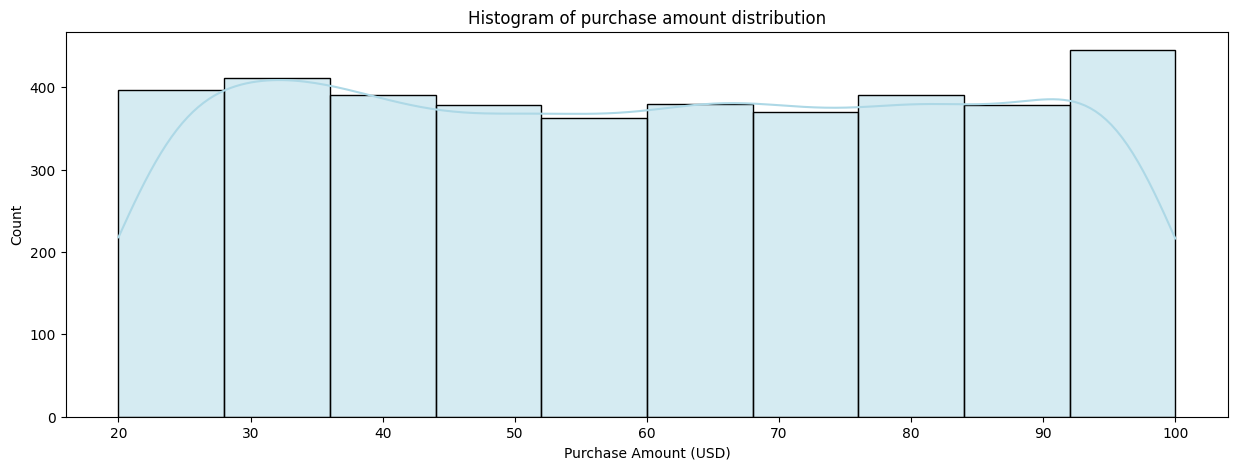

In [140]:
plt.figure(figsize=(15,5))
plt.title('Histogram of purchase amount distribution')
sns.histplot(data=df, x='Purchase Amount (USD)', bins = 10, color = 'lightblue', kde=True)
plt.show()

In the histogram above, we can observe that the amounts spent on shopping ranged from \\$20 to \\$100. The highest frequency is observed in the \\$30-\\$40 and \\$90-\\$100 ranges. The amounts in the remaining ranges are distributed relatively evenly.

## Answers to the questions posed.

## 1. **What are the most frequently purchased product categories in different seasons?**

In [141]:
category_season = df.groupby(['Season','Category']).size().reset_index(name='Count')
most_frequently_cat = category_season.loc[category_season.groupby('Season')['Count'].idxmax()].sort_values(by='Count', ascending=False)
most_frequently_cat

,Season,Category,Count
5,Spring,Clothing,454
13,Winter,Clothing,448
1,Fall,Clothing,427
9,Summer,Clothing,408


#### Among the available categories, the most frequently purchased products are from the **Clothing** category.

## 2. **Is there a relationship between the customer's age and the average review rating given by them?**

In [142]:
age_rating = df.groupby('Age')['Review Rating'].mean().reset_index()

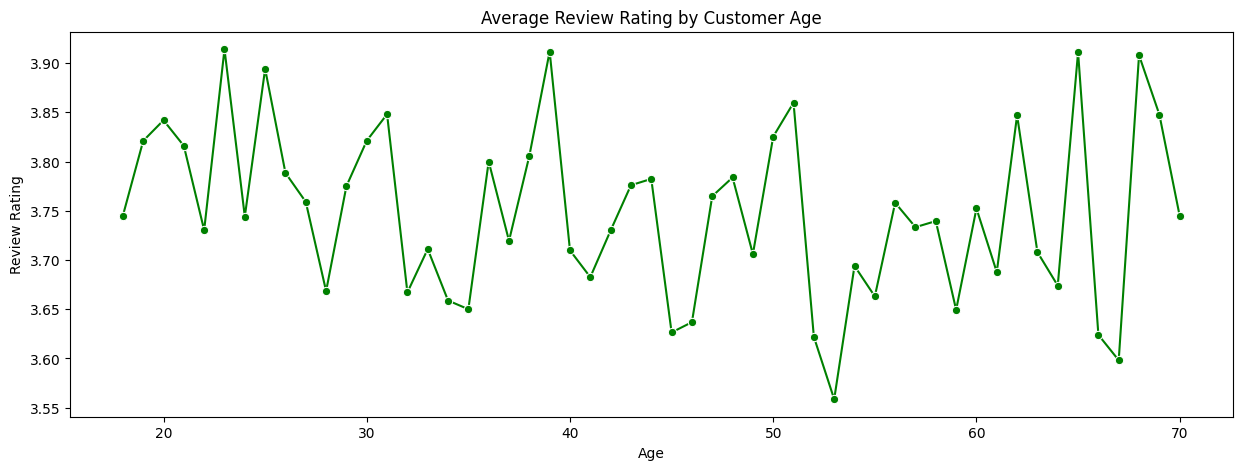

In [143]:
plt.figure(figsize=(15,5))
sns.lineplot(data=age_rating, x='Age', y='Review Rating', marker='o', color='g')
plt.title('Average Review Rating by Customer Age')
plt.show()

Based on the line chart showing the average rating for each customer age, no clear trends can be observed. This suggests that there is no strong correlation between a customer's age and the rating they give. It is possible that the rating depends on other factors.

In [144]:
# Let's check the correlation rate between the Age and Review Rating variables

df['Age'].corr(df['Review Rating'])

-0.021949148075933254

The correlation rate between customers' age and review rating is -0.022, indicating no significant relationship between these variables. The age of customers has virtually no impact on the ratings they give. Ratings are likely determined by other factors, such as product quality, shopping experience, or the shopping season.

## 3. **Which product color is the most popular among customers from different locations?**

In [211]:
location_colors = df.groupby(['Location', 'Color']).size().reset_index(name='Count')

max_counts = location_colors.groupby('Location')['Count'].transform('max')

most_popular_colors = location_colors.loc[location_colors['Count'] == max_counts]
most_popular_colors.loc[most_popular_colors.duplicated(subset='Location'),'Location'] =''
most_popular_colors.reset_index(drop=True)


,Location,Color,Count
0,Alabama,Magenta,6
1,,Red,6
2,Alaska,Green,6
3,,Olive,6
4,Arizona,Yellow,6
...,...,...,...
68,Virginia,Turquoise,7
69,Washington,Silver,6
70,West Virginia,Violet,6
71,Wisconsin,Silver,7
